In [1]:
!pip install av
!pip install torch
!pip install librosa
!pip install os
!pip install json
!pip install torchvision
!pip install torchaudio
!pip install h5py
#!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 124.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 77.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 138.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 151.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 141.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 211.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 99.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 142.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 249.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 156.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 141.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/2

In [1]:
import numpy as np
import librosa
import os
import json
import matplotlib.pyplot as plt
import av
import h5py
#import seaborn as sns
import sklearn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


In [2]:
import torch
import torchvision
import torchaudio
import torch.nn as nn

from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchvision.io import read_video
from torchvision.models.video import r3d_18
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
# Check if CUDA (NVIDIA GPU) is available
gpu_available = torch.cuda.is_available()
print(f"CUDA Available: {gpu_available}")

if gpu_available:
    # Get the GPU name
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    
    # Get the number of GPUs
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    
    # Get the current GPU memory usage
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
    
    # Test a simple tensor operation on GPU
    x = torch.rand(3, 3).cuda()
    print("Tensor successfully created on GPU:", x)
else:
    print("CUDA is not available. Running on CPU.")

CUDA Available: True
GPU Name: NVIDIA H100 80GB HBM3
Number of GPUs: 1
GPU Memory Allocated: 0.00 MB
GPU Memory Reserved: 0.00 MB
Tensor successfully created on GPU: tensor([[0.7457, 0.2001, 0.8995],
        [0.8750, 0.8683, 0.1055],
        [0.4326, 0.8927, 0.2116]], device='cuda:0')


In [4]:
# Set seed for reproducibility
def set_seed(seed=42):
    import random
    import torch.backends.cudnn as cudnn
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

In [7]:
!jupyter trust classification_finetuned.ipynb

Signing notebook: classification_finetuned.ipynb


# data loading

In [7]:
# z-score normalization 
# Load data list from JSON lines
def load_data_list(file_path='data_copy.list'):
    data_list = []
    all_keys =[]
    skipped = 0
    loaded = 0
    with open(file_path, 'r') as f:
        for line_num, line in enumerate(f, 1):
            if not line.strip():
                continue
            try:
                entry = json.loads(line.strip())
                if 'key' not in entry or 'wav_path' not in entry or 'label' not in entry:
                    print(f"Key error at line {line_num}: Missing 'key', 'wav_path', or 'label', line content: {line.strip()}")
                    skipped += 1
                    continue
                key = entry['key']
                wav_path = os.path.join('audio', os.path.basename(entry['wav_path']))
                video_path = os.path.join('video', os.path.splitext(os.path.basename(entry['wav_path']))[0] + '.avi')
                label = int(entry['label'])
                if label not in [0, 1, 2, 3]:
                    skipped += 1
                    continue
                spec_path = os.path.join('spectrograms', f'spec_{key}.npy')
                if not os.path.exists(wav_path) or not os.path.exists(video_path) or not os.path.exists(spec_path):
                    skipped += 1
                    continue
                data_list.append((wav_path, video_path, label, key))
                loaded += 1
            except json.JSONDecodeError as e:
                print(f"JSON error at line {line_num}: {e}, line content: {line.strip()}, skipping.")
                skipped += 1
                continue
            except KeyError as e:
                print(f"Key error at line {line_num}: Missing {e}, line content: {line.strip()}, skipping.")
                skipped += 1
                continue
            all_keys.append(key)
    print(f"Loaded {loaded} valid clips, skipped {skipped} entries from {file_path}.")
    return data_list, all_keys

# Z-score normalization
def zscore_normalize(X, mean=None, std=None):
    if mean is None:
        mean = X.mean(axis=0)
    if std is None:
        std = X.std(axis=0)
    std[std == 0] = 1.0
    return (X - mean) / std, mean, std

# Load saved audio/video embeddings

def load_embeddings(indices, data_list, embeddings_dir='features_2w_finetuned', batch_size=16, normalize=True, mean_std=None):
    X_audio, X_video, y, keys = [], [], [], []
    skipped = 0
    loaded = 0
    for i in indices:
        if i >= len(data_list):
            print(f"Index {i} exceeds data_list length {len(data_list)}, skipping.")
            skipped += 1
            continue
        try:
            key = data_list[i][3]
            label = data_list[i][2]
            batch_num = i // batch_size
            audio_embed_path = os.path.join(embeddings_dir, f'batch_{batch_num}', f'audio_embed_{key}.npy')
            video_embed_path = os.path.join(embeddings_dir, f'batch_{batch_num}', f'video_embed_{key}.npy')
            if not os.path.exists(audio_embed_path) or not os.path.exists(video_embed_path):
                print(f"Missing embedding for key {key}, skipping.")
                skipped += 1
                continue
            X_audio.append(np.load(audio_embed_path))
            X_video.append(np.load(video_embed_path))
            y.append(label)
            keys.append(key)
            loaded += 1
            if loaded % 1000 == 0:
                print(f"Loaded {loaded} embeddings so far.")
        except Exception as e:
            print(f"Error loading embedding for index {i}, key {data_list[i][3]}: {e}, skipping.")
            skipped += 1
            continue
    print(f"Loaded {loaded} embeddings, skipped {skipped} entries.")

    X_audio = np.array(X_audio)
    X_video = np.array(X_video)
    y = np.array(y)

    if normalize:
        if mean_std is None:
            X_audio, audio_mean, audio_std = zscore_normalize(X_audio)
            X_video, video_mean, video_std = zscore_normalize(X_video)
            mean_std = (audio_mean, audio_std, video_mean, video_std)
        else:
            audio_mean, audio_std, video_mean, video_std = mean_std
            X_audio, _, _ = zscore_normalize(X_audio, audio_mean, audio_std)
            X_video, _, _ = zscore_normalize(X_video, video_mean, video_std)

    return X_audio, X_video, y, keys, mean_std

# Load train/val/test indices
try:
    train_indices = np.load('train_indices.npy')
    val_indices = np.load('val_indices.npy')
    test_indices = np.load('test_indices.npy')
    print(f"Train indices: {len(train_indices)}, Val indices: {len(val_indices)}, Test indices: {len(test_indices)}")
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure train_indices.npy, val_indices.npy, test_indices.npy exist.")
    raise

# Load full data list
data_list, all_keys = load_data_list('data_copy.list')

# Sanity check on indices
max_index = len(data_list) - 1
if max(train_indices) > max_index or max(val_indices) > max_index or max(test_indices) > max_index:
    print(f"Error: Indices exceed data_list length ({max_index}). Re-run split_dataset.py with data_copy.list.")
    raise ValueError("Invalid indices.")

# Load embeddings into memory
print("Loading training embeddings...")
X_train_audio, X_train_video, y_train, train_keys, mean_std = load_embeddings(train_indices, data_list, embeddings_dir='features_2w_finetuned', batch_size=16, normalize=True)
print("Loading validation embeddings...")
X_val_audio, X_val_video, y_val, val_keys, _ = load_embeddings(val_indices, data_list, embeddings_dir='features_2w_finetuned', batch_size=16, normalize=True, mean_std=mean_std)
print("Loading test embeddings...")
X_test_audio, X_test_video, y_test, test_keys, _ = load_embeddings(test_indices, data_list, embeddings_dir='features_2w_finetuned', batch_size=16, normalize=True, mean_std=mean_std)

# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(X_train_audio, dtype=torch.float32),
                               torch.tensor(X_train_video, dtype=torch.float32),
                               torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_audio, dtype=torch.float32),
                             torch.tensor(X_val_video, dtype=torch.float32),
                             torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_audio, dtype=torch.float32),
                              torch.tensor(X_test_video, dtype=torch.float32),
                              torch.tensor(y_test, dtype=torch.long))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train indices: 41734, Val indices: 9465, Test indices: 9277
JSON error at line 1919: Extra data: line 1 column 120 (char 119), line content: {"key": "S_M_00051_G2_task1_4_S00004", "wav_path": "data/S_M_00051_G2_task1_4_S00004.wav", "label": 1, "Frenchay": 114}4{"key": "S_M_00020_G4_task1_5_S00007", "wav_path": "data/S_M_00020_G4_task1_5_S00007.wav", "label": 1, "Frenchay": 92}, skipping.
Loaded 60476 valid clips, skipped 6712 entries from data_copy.list.
Loading training embeddings...
Loaded 1000 embeddings so far.
Loaded 2000 embeddings so far.
Loaded 3000 embeddings so far.
Loaded 4000 embeddings so far.
Loaded 5000 embeddings so far.
Loaded 6000 embeddings so far.
Loaded 7000 embeddings so far.
Loaded 8000 embeddings so far.
Loaded 9000 embeddings so far.
Loaded 10000 embeddings so far.


KeyboardInterrupt: 

In [ ]:
# l2 norm
# Load data list from JSON lines
def load_data_list(file_path='data_copy.list'):
    data_list = []
    all_keys =[]
    skipped = 0
    loaded = 0
    with open(file_path, 'r') as f:
        for line_num, line in enumerate(f, 1):
            if not line.strip():
                continue
            try:
                entry = json.loads(line.strip())
                if 'key' not in entry or 'wav_path' not in entry or 'label' not in entry:
                    print(f"Key error at line {line_num}: Missing 'key', 'wav_path', or 'label', line content: {line.strip()}")
                    skipped += 1
                    continue
                key = entry['key']
                wav_path = os.path.join('audio', os.path.basename(entry['wav_path']))
                video_path = os.path.join('video', os.path.splitext(os.path.basename(entry['wav_path']))[0] + '.avi')
                label = int(entry['label'])
                if label not in [0, 1, 2, 3]:
                    skipped += 1
                    continue
                spec_path = os.path.join('spectrograms', f'spec_{key}.npy')
                if not os.path.exists(wav_path) or not os.path.exists(video_path) or not os.path.exists(spec_path):
                    skipped += 1
                    continue
                data_list.append((wav_path, video_path, label, key))
                loaded += 1
            except json.JSONDecodeError as e:
                print(f"JSON error at line {line_num}: {e}, line content: {line.strip()}, skipping.")
                skipped += 1
                continue
            except KeyError as e:
                print(f"Key error at line {line_num}: Missing {e}, line content: {line.strip()}, skipping.")
                skipped += 1
                continue
            all_keys.append(key)
    print(f"Loaded {loaded} valid clips, skipped {skipped} entries from {file_path}.")
    return data_list, all_keys

# Normalize embeddings (L2)
def l2_normalize(X):
    return X / np.linalg.norm(X, axis=1, keepdims=True)

# Load saved audio/video embeddings

def load_embeddings(indices, data_list, embeddings_dir='features_finetuned', batch_size=16):
    X_audio, X_video, y = [], [], []
    skipped = 0
    loaded = 0
    for i in indices:
        if i >= len(data_list):
            print(f"Index {i} exceeds data_list length {len(data_list)}, skipping.")
            skipped += 1
            continue
        try:
            key = data_list[i][3]
            label = data_list[i][2]
            batch_num = i // batch_size
            audio_embed_path = os.path.join(embeddings_dir, f'batch_{batch_num}', f'audio_embed_{key}.npy')
            video_embed_path = os.path.join(embeddings_dir, f'batch_{batch_num}', f'video_embed_{key}.npy')
            if not os.path.exists(audio_embed_path) or not os.path.exists(video_embed_path):
                print(f"Missing embedding for key {key}, skipping.")
                skipped += 1
                continue
            X_audio.append(np.load(audio_embed_path))
            X_video.append(np.load(video_embed_path))
            y.append(label)
            loaded += 1
            if loaded % 5000 == 0:
                print(f"Loaded {loaded} embeddings so far.")
        except Exception as e:
            print(f"Error loading embedding for index {i}, key {data_list[i][3]}: {e}, skipping.")
            skipped += 1
            continue
    print(f"Loaded {loaded} embeddings, skipped {skipped} entries.")
    # Normalize before returning
    return l2_normalize(np.array(X_audio)), l2_normalize(np.array(X_video)), np.array(y)

# Load train/val/test indices
try:
    train_indices = np.load('train_indices.npy')
    val_indices = np.load('val_indices.npy')
    test_indices = np.load('test_indices.npy')
    print(f"Train indices: {len(train_indices)}, Val indices: {len(val_indices)}, Test indices: {len(test_indices)}")
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure train_indices.npy, val_indices.npy, test_indices.npy exist.")
    raise

# Load full data list
data_list, all_keys = load_data_list('data_copy.list')

# Sanity check on indices
max_index = len(data_list) - 1
if max(train_indices) > max_index or max(val_indices) > max_index or max(test_indices) > max_index:
    print(f"Error: Indices exceed data_list length ({max_index}). Re-run split_dataset.py with data_copy.list.")
    raise ValueError("Invalid indices.")

# Load embeddings into memory
print("Loading training embeddings...")
X_train_audio, X_train_video, y_train = load_embeddings(train_indices, data_list, embeddings_dir='features_finetuned', batch_size=16)
print("Loading validation embeddings...")
X_val_audio, X_val_video, y_val = load_embeddings(val_indices, data_list, embeddings_dir='features_finetuned', batch_size=16)
print("Loading test embeddings...")
X_test_audio, X_test_video, y_test = load_embeddings(test_indices, data_list, embeddings_dir='features_finetuned', batch_size=16)

# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(X_train_audio, dtype=torch.float32),
                               torch.tensor(X_train_video, dtype=torch.float32),
                               torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_audio, dtype=torch.float32),
                             torch.tensor(X_val_video, dtype=torch.float32),
                             torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_audio, dtype=torch.float32),
                              torch.tensor(X_test_video, dtype=torch.float32),
                              torch.tensor(y_test, dtype=torch.long))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train indices: 41734, Val indices: 9465, Test indices: 9277
JSON error at line 1919: Extra data: line 1 column 120 (char 119), line content: {"key": "S_M_00051_G2_task1_4_S00004", "wav_path": "data/S_M_00051_G2_task1_4_S00004.wav", "label": 1, "Frenchay": 114}4{"key": "S_M_00020_G4_task1_5_S00007", "wav_path": "data/S_M_00020_G4_task1_5_S00007.wav", "label": 1, "Frenchay": 92}, skipping.
Loaded 60476 valid clips, skipped 6712 entries from data_copy.list.
Loading training embeddings...
Loaded 5000 embeddings so far.
Loaded 10000 embeddings so far.
Loaded 15000 embeddings so far.
Loaded 20000 embeddings so far.


In [ ]:
# no normalization 
# Load data list from JSON lines
def load_data_list(file_path='data_copy.list'):
    data_list = []
    all_keys =[]
    skipped = 0
    loaded = 0
    with open(file_path, 'r') as f:
        for line_num, line in enumerate(f, 1):
            if not line.strip():
                continue
            try:
                entry = json.loads(line.strip())
                if 'key' not in entry or 'wav_path' not in entry or 'label' not in entry:
                    print(f"Key error at line {line_num}: Missing 'key', 'wav_path', or 'label', line content: {line.strip()}")
                    skipped += 1
                    continue
                key = entry['key']
                wav_path = os.path.join('audio', os.path.basename(entry['wav_path']))
                video_path = os.path.join('video', os.path.splitext(os.path.basename(entry['wav_path']))[0] + '.avi')
                label = int(entry['label'])
                if label not in [0, 1, 2, 3]:
                    skipped += 1
                    continue
                spec_path = os.path.join('spectrograms', f'spec_{key}.npy')
                if not os.path.exists(wav_path) or not os.path.exists(video_path) or not os.path.exists(spec_path):
                    skipped += 1
                    continue
                data_list.append((wav_path, video_path, label, key))
                loaded += 1
            except json.JSONDecodeError as e:
                print(f"JSON error at line {line_num}: {e}, line content: {line.strip()}, skipping.")
                skipped += 1
                continue
            except KeyError as e:
                print(f"Key error at line {line_num}: Missing {e}, line content: {line.strip()}, skipping.")
                skipped += 1
                continue
            all_keys.append(key)
    print(f"Loaded {loaded} valid clips, skipped {skipped} entries from {file_path}.")
    return data_list, all_keys
'''
# Normalize embeddings (L2)
def l2_normalize(X):
    return X / np.linalg.norm(X, axis=1, keepdims=True)
'''

# Load saved audio/video embeddings

def load_embeddings(indices, data_list, embeddings_dir='features_finetuned', batch_size=16):
    X_audio, X_video, y = [], [], []
    skipped = 0
    loaded = 0
    for i in indices:
        if i >= len(data_list):
            print(f"Index {i} exceeds data_list length {len(data_list)}, skipping.")
            skipped += 1
            continue
        try:
            key = data_list[i][3]
            label = data_list[i][2]
            batch_num = i // batch_size
            audio_embed_path = os.path.join(embeddings_dir, f'batch_{batch_num}', f'audio_embed_{key}.npy')
            video_embed_path = os.path.join(embeddings_dir, f'batch_{batch_num}', f'video_embed_{key}.npy')
            if not os.path.exists(audio_embed_path) or not os.path.exists(video_embed_path):
                print(f"Missing embedding for key {key}, skipping.")
                skipped += 1
                continue
            X_audio.append(np.load(audio_embed_path))
            X_video.append(np.load(video_embed_path))
            y.append(label)
            loaded += 1
            if loaded % 5000 == 0:
                print(f"Loaded {loaded} embeddings so far.")
        except Exception as e:
            print(f"Error loading embedding for index {i}, key {data_list[i][3]}: {e}, skipping.")
            skipped += 1
            continue
    print(f"Loaded {loaded} embeddings, skipped {skipped} entries.")
    # Normalize before returning
    #return l2_normalize(np.array(X_audio)), l2_normalize(np.array(X_video)), np.array(y)
    return np.array(X_audio), np.array(X_video), np.array(y)

# Load train/val/test indices
try:
    train_indices = np.load('train_indices.npy')
    val_indices = np.load('val_indices.npy')
    test_indices = np.load('test_indices.npy')
    print(f"Train indices: {len(train_indices)}, Val indices: {len(val_indices)}, Test indices: {len(test_indices)}")
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure train_indices.npy, val_indices.npy, test_indices.npy exist.")
    raise

# Load full data list
data_list, all_keys = load_data_list('data_copy.list')

# Sanity check on indices
max_index = len(data_list) - 1
if max(train_indices) > max_index or max(val_indices) > max_index or max(test_indices) > max_index:
    print(f"Error: Indices exceed data_list length ({max_index}). Re-run split_dataset.py with data_copy.list.")
    raise ValueError("Invalid indices.")

# Load embeddings into memory
print("Loading training embeddings...")
X_train_audio, X_train_video, y_train = load_embeddings(train_indices, data_list, embeddings_dir='features_finetuned', batch_size=16)
print("Loading validation embeddings...")
X_val_audio, X_val_video, y_val = load_embeddings(val_indices, data_list, embeddings_dir='features_finetuned', batch_size=16)
print("Loading test embeddings...")
X_test_audio, X_test_video, y_test = load_embeddings(test_indices, data_list, embeddings_dir='features_finetuned', batch_size=16)

# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(X_train_audio, dtype=torch.float32),
                               torch.tensor(X_train_video, dtype=torch.float32),
                               torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_audio, dtype=torch.float32),
                             torch.tensor(X_val_video, dtype=torch.float32),
                             torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_audio, dtype=torch.float32),
                              torch.tensor(X_test_video, dtype=torch.float32),
                              torch.tensor(y_test, dtype=torch.long))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train indices: 41734, Val indices: 9465, Test indices: 9277
JSON error at line 1919: Extra data: line 1 column 120 (char 119), line content: {"key": "S_M_00051_G2_task1_4_S00004", "wav_path": "data/S_M_00051_G2_task1_4_S00004.wav", "label": 1, "Frenchay": 114}4{"key": "S_M_00020_G4_task1_5_S00007", "wav_path": "data/S_M_00020_G4_task1_5_S00007.wav", "label": 1, "Frenchay": 92}, skipping.
Loaded 60476 valid clips, skipped 6712 entries from data_copy.list.
Loading training embeddings...
Loaded 5000 embeddings so far.
Loaded 10000 embeddings so far.
Loaded 15000 embeddings so far.
Loaded 20000 embeddings so far.


In [ ]:
# Function to extract participant ID from the key
def extract_participant_id(key):
    # Split the key by underscores and take the first 3 components
    # e.g., "N_M_10010_G4_task3_4_04" -> "N_M_10010"
    parts = key.split('_')
    if len(parts) < 3:
        return None  # Invalid key format
    if 'repeat' in parts:
      participant_id = parts[1] + '_' + parts[2] + '_' + parts[3]
    else:
      participant_id = parts[0] + '_' + parts[1] + '_' + parts[2]
    return participant_id

# Function to extract participant characteristics
def get_participant_info(participant_id):
    parts = participant_id.split('_')
    if len(parts) != 3:
        return None, None
    health_status = 'Healthy' if parts[0] == 'N' else 'Patient'
    gender = 'Male' if parts[1] == 'M' else 'Female'
    return health_status, gender


# Calculate distribution, store labels, participant ID, health_status and gender
def calculate_participant_distribution(keys):
    # Dictionary to store counts of clips per participant
    participant_counts = defaultdict(int)
    # Dictionaries to store counts by health status and gender
    health_gender_counts = defaultdict(lambda: defaultdict(int))

    # list to store the participant ID
    participant_id_list = []
    # list to store the health status and genders
    health_gender_list = []


    # Group by participant
    for key in keys:
        participant_id = extract_participant_id(key)
        if participant_id is None:
            continue
        participant_id_list.append(participant_id)  #store the participant ID
        # Increment count for this participant
        participant_counts[participant_id] += 1

        # Get health status and gender
        health_status, gender = get_participant_info(participant_id)
        if health_status and gender:
            health_gender_counts[health_status][gender] += 1
        health_gender_list.append(health_status+gender)

    # Convert to lists for analysis
    participants = list(participant_counts.keys())
    counts = list(participant_counts.values())

    return participants, counts, health_gender_counts, participant_id_list, health_gender_list

# Calculate
participants, counts, health_gender_counts, participant_id_list, health_gender_list= calculate_participant_distribution(all_keys)

In [ ]:
def check_embedding_scale(X_audio, X_video):
    """
    Prints basic scale statistics for audio and video embeddings.
    
    Args:
        X_audio (np.ndarray): Audio embeddings, shape [N, D]
        X_video (np.ndarray): Video embeddings, shape [N, D]
    """
    def print_stats(name, X):
        print(f"\n{name} Embeddings:")
        print(f"  Shape: {X.shape}")
        print(f"  Min: {np.min(X):.4f}")
        print(f"  Max: {np.max(X):.4f}")
        print(f"  Mean: {np.mean(X):.4f}")
        print(f"  Std: {np.std(X):.4f}")

    print_stats("Audio", X_audio)
    print_stats("Video", X_video)
check_embedding_scale(X_train_audio, X_train_video)

In [10]:
# Analyze label distribution
def print_label_distribution(y, set_name):
    counter = Counter(y)
    total = len(y)
    print(f"\n{set_name} Label Distribution:")
    for label in range(4):
        count = counter.get(label, 0)
        percentage = (count / total * 100) if total > 0 else 0
        print(f"Label {label}: {count} clips ({percentage:.2f}%)")



# Get labels from loaders
def get_labels(loader):
    labels = []
    for _, _, lbls in loader:
        labels.extend(lbls.numpy())
    return np.array(labels)

print_label_distribution(get_labels(train_loader), "Training")
print_label_distribution(get_labels(val_loader), "Validation")
print_label_distribution(get_labels(test_loader), "Test")


Training Label Distribution:
Label 0: 9044 clips (21.67%)
Label 1: 19959 clips (47.82%)
Label 2: 7405 clips (17.74%)
Label 3: 5326 clips (12.76%)

Validation Label Distribution:
Label 0: 808 clips (8.54%)
Label 1: 4580 clips (48.39%)
Label 2: 2597 clips (27.44%)
Label 3: 1480 clips (15.64%)

Test Label Distribution:
Label 0: 2058 clips (22.18%)
Label 1: 4650 clips (50.12%)
Label 2: 2423 clips (26.12%)
Label 3: 146 clips (1.57%)


# trianing 

In [11]:
class LinearFusionClassifier(nn.Module):
    def __init__(self, audio_dim=512, video_dim=512, proj_dim=128, num_classes=4):
        super(LinearFusionClassifier, self).__init__()

        # Separate projection layers
        self.audio_proj = nn.Linear(audio_dim, proj_dim)
        self.video_proj = nn.Linear(video_dim, proj_dim)

        # Linear classifier on concatenated projections
        self.classifier = nn.Linear(2 * proj_dim, num_classes)

    def forward(self, audio_embeds, video_embeds):
        a = self.audio_proj(audio_embeds)  # (B, 128)
        v = self.video_proj(video_embeds)  # (B, 128)
        x = torch.cat([a, v], dim=1)       # (B, 256)
        return self.classifier(x)          # (B, num_classes)

In [18]:
# mlp -- combined -128
class MLPFusionClassifier(nn.Module):
    def __init__(self, audio_dim=512, video_dim=512, hidden_dim=128, num_classes=4, dropout_rate=0.3):
        super(MLPFusionClassifier, self).__init__()

        # Project both modalities to hidden_dim
        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.video_proj = nn.Linear(video_dim, hidden_dim)

        # Classifier on [audio_128 | video_128] = (B, 256)
        self.classifier = nn.Sequential(
            nn.LayerNorm(2 * hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(2 * hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, audio_embeds, video_embeds):
        a = self.audio_proj(audio_embeds)  # (B, 128)
        v = self.video_proj(video_embeds)  # (B, 128)
        x = torch.cat([a, v], dim=1)       # (B, 256)
        return self.classifier(x)          # (B, num_classes)

In [9]:
# Cross-attention classifier --512 -- audio query
class CrossAttentionClassifier(nn.Module):
    def __init__(self, embed_dim=512, num_classes=4, dropout_rate=0.5):
        super(CrossAttentionClassifier, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=1, batch_first=True)
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, audio_embeds, video_embeds):
        audio_q = audio_embeds.unsqueeze(1)  # (B, 1, 512)
        video_kv = video_embeds.unsqueeze(1)  # (B, 1, 512)
        attn_output, _ = self.attn(query=audio_q, key=video_kv, value=video_kv)
        output = self.classifier(attn_output.squeeze(1))
        return output

In [10]:
# Cross-attention classifier --128 --audio query
class CrossAttentionClassifier(nn.Module):
    def __init__(self, embed_dim=512, hidden_dim=128, num_classes=4, dropout_rate=0.3):
        super(CrossAttentionClassifier, self).__init__()
        self.audio_proj = nn.Linear(embed_dim, hidden_dim)
        self.video_proj = nn.Linear(embed_dim, hidden_dim)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, batch_first=True)
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, audio_embeds, video_embeds):
        # Project both audio and video to hidden_dim
        audio_q = self.audio_proj(audio_embeds).unsqueeze(1)  # (B, 1, hidden_dim)
        video_kv = self.video_proj(video_embeds).unsqueeze(1)  # (B, 1, hidden_dim)
        attn_output, _ = self.attn(query=audio_q, key=video_kv, value=video_kv)
        output = self.classifier(attn_output.squeeze(1))
        return output


In [10]:
# Cross-attention classifier --128 --video query
class CrossAttentionClassifier(nn.Module):
    def __init__(self, embed_dim=512, hidden_dim=128, num_classes=4, dropout_rate=0.3):
        super(CrossAttentionClassifier, self).__init__()
        self.audio_proj = nn.Linear(embed_dim, hidden_dim)
        self.video_proj = nn.Linear(embed_dim, hidden_dim)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1, batch_first=True)
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, audio_embeds, video_embeds):
        # Project both audio and video to hidden_dim
        audio_kv = self.audio_proj(audio_embeds).unsqueeze(1)  # (B, 1, hidden_dim)
        video_q = self.video_proj(video_embeds).unsqueeze(1)  # (B, 1, hidden_dim)
        attn_output, _ = self.attn(query=video_q, key=audio_kv, value=audio_kv)
        output = self.classifier(attn_output.squeeze(1))
        return output

In [9]:
# Define self-attention classifier
class SelfAttentionClassifier(nn.Module):
    def __init__(self, input_dim=512, proj_dim=128, num_classes=4):
        super().__init__()
        # Projection layers
        self.audio_proj = nn.Sequential(
            nn.Linear(input_dim, proj_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.video_proj = nn.Sequential(
            nn.Linear(input_dim, proj_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        # Self-attention parameters (operate on 256-D after concatenation)
        self.query = nn.Linear(proj_dim * 2, proj_dim * 2)
        self.key = nn.Linear(proj_dim * 2, proj_dim * 2)
        self.value = nn.Linear(proj_dim * 2, proj_dim * 2)
        self.scale = torch.sqrt(torch.tensor(proj_dim * 2, dtype=torch.float32))
        self.attn_dropout = nn.Dropout(0.5)
        # Classification head
        self.fc = nn.Linear(proj_dim * 2, num_classes)
    
    def forward(self, audio, video):
        # Project to 128-D
        audio = self.audio_proj(audio)  # (batch, 128)
        video = self.video_proj(video)  # (batch, 128)
        # Concatenate
        x = torch.cat([audio, video], dim=1)  # (batch, 256)
        # Single-head self-attention
        q = self.query(x).unsqueeze(1)  # (batch, 1, 256)
        k = self.key(x).unsqueeze(1)    # (batch, 1, 256)
        v = self.value(x).unsqueeze(1)  # (batch, 1, 256)
        attn_scores = torch.bmm(q, k.transpose(1, 2)) / self.scale  # (batch, 1, 1)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        attn_output = torch.bmm(attn_weights, v).squeeze(1)  # (batch, 256)
        # Classification
        logits = self.fc(attn_output)
        return logits

In [8]:
#multi-head attention
class MultiHeadFusionClassifier(nn.Module):
    def __init__(self, input_dim=512, proj_dim=128, num_heads=4, num_classes=4, dropout=0.3):
        super().__init__()
        
        # Project both modalities to a shared space
        self.audio_proj = nn.Linear(input_dim, proj_dim)
        self.video_proj = nn.Linear(input_dim, proj_dim)

        # Multihead self-attention over [audio, video]
        self.attn = nn.MultiheadAttention(embed_dim=proj_dim, num_heads=num_heads, batch_first=True, dropout=dropout)

        # Classifier
        self.classifier = nn.Sequential(
            nn.LayerNorm(proj_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(proj_dim, num_classes)
        )

    def forward(self, audio_embed, video_embed):
        # Project audio/video to same space
        a = self.audio_proj(audio_embed)  # (B, D)
        v = self.video_proj(video_embed)  # (B, D)

        # Stack into sequence: (B, 2, D)
        x = torch.stack([a, v], dim=1)

        # Self-attention over modalities
        attn_out, _ = self.attn(x, x, x)  # (B, 2, D)

        # Pool: mean or max over modalities
        fused = attn_out.mean(dim=1)  # (B, D)

        # Classification
        return self.classifier(fused)

In [19]:
# Training function for one epoch
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for audio, video, labels in train_loader:
        audio, video, labels = audio.to(device), video.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(audio, video)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * audio.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    train_loss /= train_total
    train_acc = train_correct / train_total * 100
    return train_loss, train_acc

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for audio, video, labels in val_loader:
            audio, video, labels = audio.to(device), video.to(device), labels.to(device)
            outputs = model(audio, video)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * audio.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss /= val_total
    val_acc = val_correct / val_total * 100
    return val_loss, val_acc

# Testing function with classification report
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for audio, video, labels in test_loader:
            audio, video, labels = audio.to(device), video.to(device), labels.to(device)
            outputs = model(audio, video)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * audio.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_loss /= test_total
    test_acc = test_correct / test_total * 100
    
    # Generate classification report
    print("\nTest Set Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(4)], digits=4))
    
    return test_loss, test_acc, all_labels, all_preds

# Training loop function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30, best_model_path='classifier.pth'):
    best_val_acc = 0.0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Step the scheduler
        scheduler.step(val_loss)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with Val Acc: {best_val_acc:.2f}%")
    
    return train_losses, train_accs, val_losses, val_accs



Training model...
Epoch 1/30, Train Loss: 0.0507, Train Acc: 99.39%, Val Loss: 3.2979, Val Acc: 39.83%
Saved best model with Val Acc: 39.83%
Epoch 2/30, Train Loss: 0.0005, Train Acc: 100.00%, Val Loss: 3.9531, Val Acc: 39.63%
Epoch 3/30, Train Loss: 0.0002, Train Acc: 100.00%, Val Loss: 4.2799, Val Acc: 40.27%
Saved best model with Val Acc: 40.27%
Epoch 4/30, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 4.3627, Val Acc: 40.20%
Epoch 5/30, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 4.5554, Val Acc: 40.54%
Saved best model with Val Acc: 40.54%
Epoch 6/30, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 4.5382, Val Acc: 40.90%
Saved best model with Val Acc: 40.90%
Epoch 7/30, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 4.8251, Val Acc: 41.09%
Saved best model with Val Acc: 41.09%
Epoch 8/30, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 4.6051, Val Acc: 40.93%
Epoch 9/30, Train Loss: 0.0001, Train Acc: 100.00%, Val Loss: 5.6855, Val Acc: 39.81%
Epoch 10/30, Train 

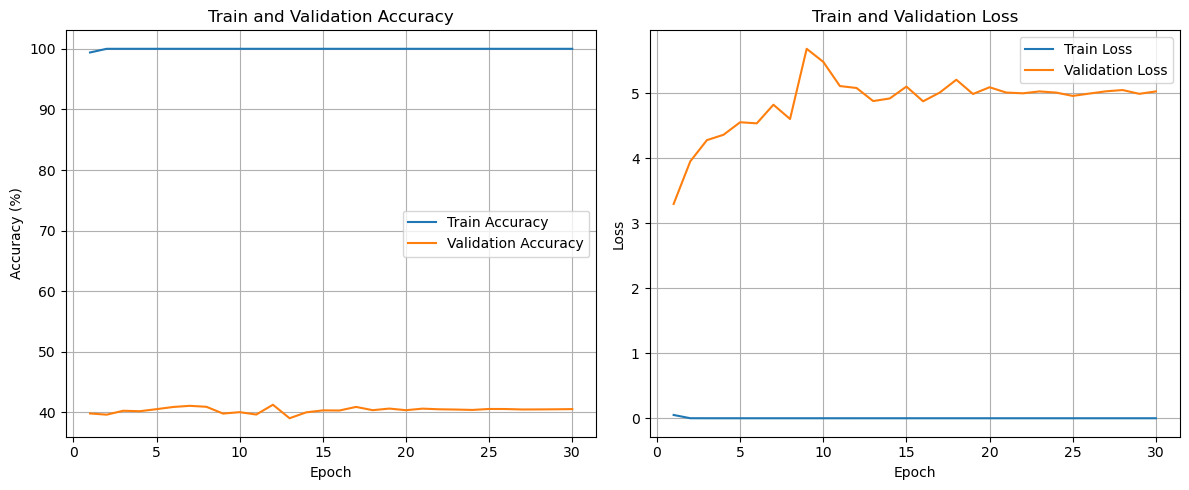

Saved training metrics plot as 'training_metrics.png'


In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Compute weights inversely proportional to class frequency
def get_class_weights(y, num_classes=4):

    counts = Counter(y)
    total = sum(counts.values())
    weights = [total / counts.get(i, 1) for i in range(num_classes)]
    weights = torch.tensor(weights, dtype=torch.float32)
    return weights / weights.sum()
# Usage
class_weights = get_class_weights(y_train, num_classes=4).to(device)
# Initialize model, loss, and optimizer

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#model = SelfAttentionClassifier().to(device)
#model = CrossAttentionClassifier().to(device)
model = MLPFusionClassifier().to(device)
#model = MultiHeadFusionClassifier().to(device)
#model = LinearFusionClassifier().to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)  #  class weights (imbalanced)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)
# Train model
print("Training model...")
train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30)

# Load best model and test
model.load_state_dict(torch.load('classifier.pth'))
test_loss, test_acc, all_labels, all_preds = test_model(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()
print("Saved training metrics plot as 'training_metrics.png'")

# ~~~

In [21]:
test_participants = np.array(participant_id_list)[test_indices] #get the participant info for all test clips

In [22]:
def compute_score(test_preds,test_labels,test_participant_list=test_participants):

    # Compute F1-score for all segments (standard classification F1-score)
    F1_segment = f1_score(test_labels, test_preds, average='macro')
    print(f"F1 Score (Segment): {F1_segment:.4f}")

    
    #Compute individual f1 score 
    # Convert lists to NumPy arrays for easier manipulation
    all_preds = np.array(test_preds)
    all_labels = np.array(test_labels)

    test_participant_np = np.array(test_participant_list)
    
    # Get unique participants
    unique_test_participant = np.unique(test_participant_np)
    
    f1_individual_scores = []
    
    # Compute F1-score for each participant
    for participant in unique_test_participant:
        indices = np.where(test_participant_np == participant)[0]  # Ensure valid indices
        if len(indices) == 0:  # Skip if no samples found
            continue  

        participant_preds = all_preds[indices]
        participant_labels = all_labels[indices]
    
        f1_individual = f1_score(participant_labels, participant_preds, average='macro')
        f1_individual_scores.append(f1_individual)
    
    # Compute overall F1-score for individuals
    F1_individual = np.mean(f1_individual_scores)
    print(f"F1 Score (Individual): {F1_individual:.4f}")


    # Final Ranking Score
    final_score = (F1_individual * 10) + F1_segment
    print(f"Final Evaluation Score: {final_score:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds))
compute_score(all_preds,all_labels)

F1 Score (Segment): 0.5114
F1 Score (Individual): 0.5208
Final Evaluation Score: 5.7197

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.92      0.79      2058
           1       0.61      0.71      0.66      4650
           2       0.53      0.15      0.24      2423
           3       0.23      0.79      0.36       146

    accuracy                           0.61      9277
   macro avg       0.52      0.64      0.51      9277
weighted avg       0.60      0.61      0.57      9277



In [ ]:
def analyze_clipwise_errors(test_preds, test_labels, test_participant_list, test_indices):
    # Convert everything to NumPy arrays
    preds = np.array(test_preds)
    labels = np.array(test_labels)
    participants = np.array(test_participant_list)
    indices = np.array(test_indices)

    # Build DataFrame to track each prediction
    df = pd.DataFrame({
        'dataset_index': indices,
        'participant': participants,
        'true_label': labels,
        'predicted_label': preds,
    })

    # Mark whether each prediction is correct
    df['correct'] = df['true_label'] == df['predicted_label']

    # Print summary
    print(f"\nCorrect predictions: {df['correct'].sum()} / {len(df)}")
    print(f"Incorrect predictions: {len(df) - df['correct'].sum()}")

    # Optional: Confusion counts
    print("\nTop mistakes (True → Predicted):")
    confusion_counts = df[~df['correct']].groupby(['true_label', 'predicted_label']).size().sort_values(ascending=False)
    print(confusion_counts.head(10))

    return df